# Split Data for Training

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
# To avoid:
# StdErr from Kernel Process OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5 already initialized.
# OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program.

import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

This code loads the data and corresponding labels, then transforms the dataset.

In [3]:
dataset = tf.data.Dataset.list_files("../data/flooddata/*/*.csv", shuffle=False)
files = []
for file in dataset:
    files.append(file.numpy().decode())
labels = []
for file in files:
    labels.append(file.split("\\")[3])
files = np.array(files)
labels = pd.Categorical(labels).rename_categories(["0.0 ft", "0.19 ft", "2.5 ft", "4.5 ft"])

During training, the network learns to associate the training signals and labels. The network may have a high training accuracy, but a network is only useful if it can generalize to new signals. We should use a separate validation and test data set to evaluate if the network can classify signals it has not yet seen. In this example, 80% of the signals will go in the training data set, 10% will go in the validation data set, and the rest (10%) will go in the testing data set.

In [4]:
files_train, files_test, labels_train, labels_test = train_test_split(files, labels, test_size=0.2, stratify=labels)
files_test, files_validation, labels_test, labels_validation = train_test_split(files_test, labels_test, test_size=0.5, stratify=labels_test)

In [5]:
print(f"files_train.shape = {files_train.shape}")
print(f"files_test.shape = {files_test.shape}")
print(f"files_validation.shape = {files_validation.shape}")

files_train.shape = (177,)
files_test.shape = (22,)
files_validation.shape = (23,)


We split the data to have equal labels proprtion.

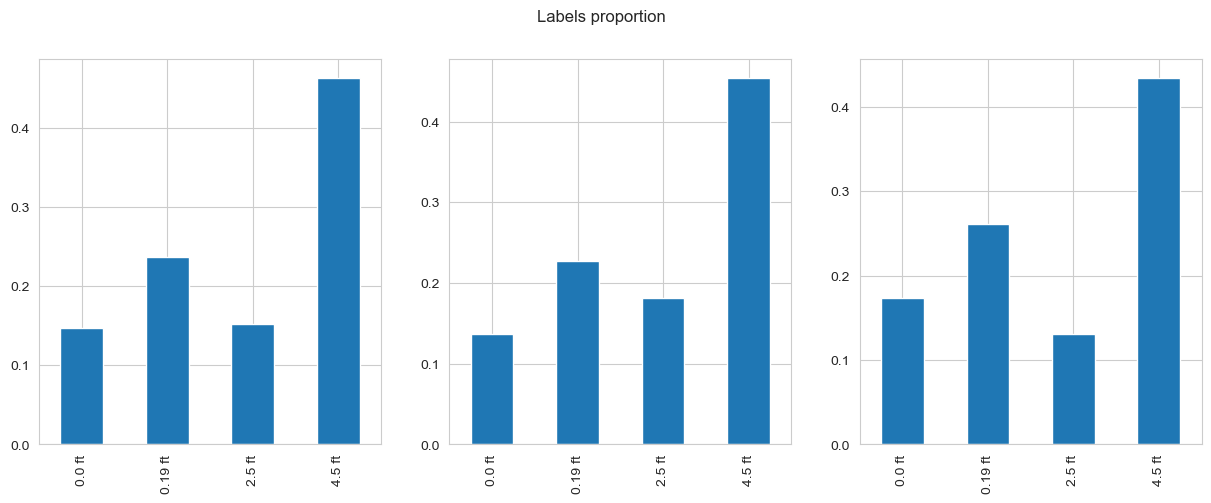

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Labels proportion')
for ax, labels in zip(axs.flatten(), [labels_train, labels_test, labels_validation]):
    pd.Series(labels).value_counts(normalize=True, sort=False).plot(kind="bar", ax=ax)
plt.show()

Create train, test and validation datasets, then create padded batches because arrays have different shapes.

In [7]:
def load_array(file):
    df = pd.read_csv(file)
    array = df.to_numpy().T
    return array

def create_dataset(files, labels):
    arrays = list(map(load_array, files))
    dataset = tf.data.Dataset.from_generator(lambda: iter(zip(arrays, labels)), output_types=(tf.float16, tf.string))
    return dataset

def configure_for_performance(dataset):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=222, reshuffle_each_iteration=True)
    dataset = dataset.padded_batch(32, padded_shapes=((3, 137), ()))
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(files_train, labels_train)
train_dataset = configure_for_performance(train_dataset)

test_dataset = create_dataset(files_test, labels_test)
test_dataset = configure_for_performance(test_dataset)

validation_dataset = create_dataset(files_validation, labels_validation)
validation_dataset = configure_for_performance(validation_dataset)

Show signals from each dataset.

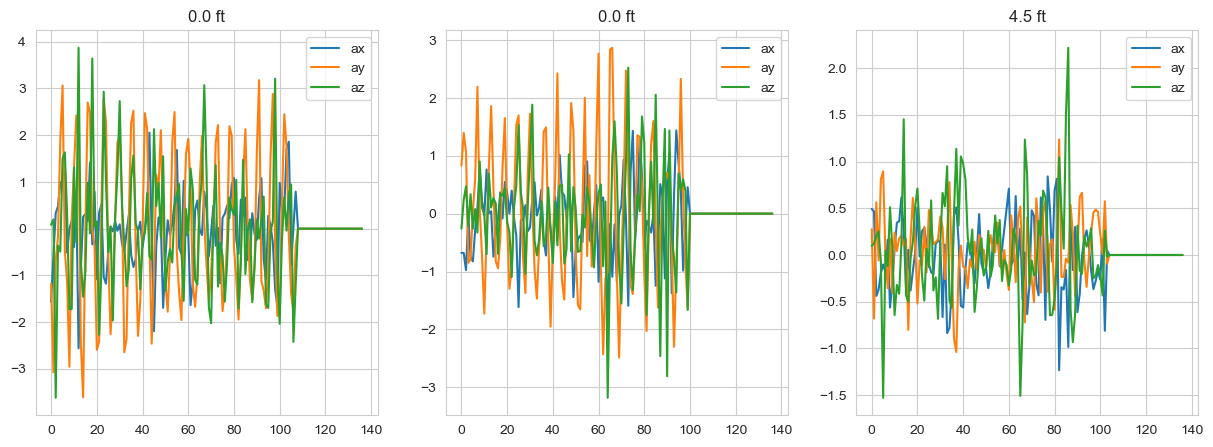

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, dataset in zip(axs.flatten(), [train_dataset, test_dataset, validation_dataset]):
    for signal, label in dataset.take(1):
        ax.plot(signal[0].numpy().T)
        ax.set_title(label[0].numpy().decode())
        ax.legend(["ax", "ay", "az"])
plt.show()